### 对图像Chapter5_1.bmp，计算粒子大小分布，并画出分布图  
提示：
选择合适的开运算结构元大小及增量步长，结构元取元素全为1的正方形结构元  
原始图像与图像开运算后相减后，还要做灰度阈值处理，只考虑哪些灰度差足够大的区域  
分布频率对应于灰度显著变化的区域的面积除以结构元大小（3*3,5*5,…)  
可用自动或手动方法排除背景干扰（即去掉自动评测的区域）！  
某一尺度下的WTH将保留比该尺度小的所有亮细节，要想得到单一尺度的亮细节，应该把比它小的细节都减去。比如WTH(n)- WTH(n-2)保留的就是尺度介于n到n-2的亮细节 （比如尺度n是(2n+1)*(2n+1)的结构元！）

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#Opencv配合jupyter notebook有问题，所以还是使用matplotlib可视化
%matplotlib inline

In [2]:
from matplotlib.image import imread
img = imread('img.pgm')
img.shape#发现是一张RGB三通道图片

(274, 279, 3)

Text(0.5, 1.0, 'Original')

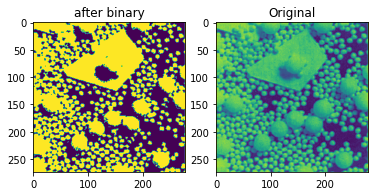

In [3]:
#转换为灰度图并进行二值化处理

gray_img=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, binary_img = cv.threshold(gray_img, 150, 1, cv.THRESH_BINARY)
plt.subplot(121)
plt.imshow(binary_img)
plt.title('after binary')
plt.subplot(122)
plt.imshow(gray_img)
plt.title('Original')

#可以看到如果先进行二值化处理，会导致失去很多细节
#所以我们先在仅灰度化的图片上先进行粒子测度,后做二值化处理

In [4]:
print(gray_img)
gray_img = gray_img[:,:-2]#发现最后两列值均为255，手动去除以免影响后续粒子测度

[[255 219 224 ...  64 255 255]
 [255 224 219 ...  59 255 255]
 [255 219 224 ...  64 255 255]
 ...
 [255 203 203 ... 155 255 255]
 [255 192 203 ... 187 255 255]
 [255 203 192 ... 192 255 255]]


In [5]:
#使用形态学顶帽变换，筛选得到图像中对应想要大小的粒子
def white_Hat(n,i,thred):#i表示步长，thred表示二值化阈值
    kernel = np.ones((n-1,n-1))
    kernel_new = np.ones((n+i,n+i))
    dst_1 = cv.morphologyEx(gray_img, cv.MORPH_TOPHAT, kernel)
    #以kernel=n-1 大小为结构元做白顶帽变换
    dst_2 = cv.morphologyEx(gray_img, cv.MORPH_TOPHAT, kernel_new)
    #以kernel_new=n+i 大小为结构元做白顶帽变换
    dst = dst_2 -dst_1#两者相减，得到size为(n,n+i-1)之间的图像
    dst = cv.morphologyEx(dst, cv.MORPH_OPEN, kernel)#在以kernel进行一次开操作去除细线
    #根据图像处理经验选择合适阈值进行二值化处理
    ret, dst = cv.threshold(dst, thred, 255, cv.THRESH_BINARY)
    a = n//i+1
    plt.subplot(12,5,a)
    plt.imshow(dst)
    plt.title(n)
    
    return dst

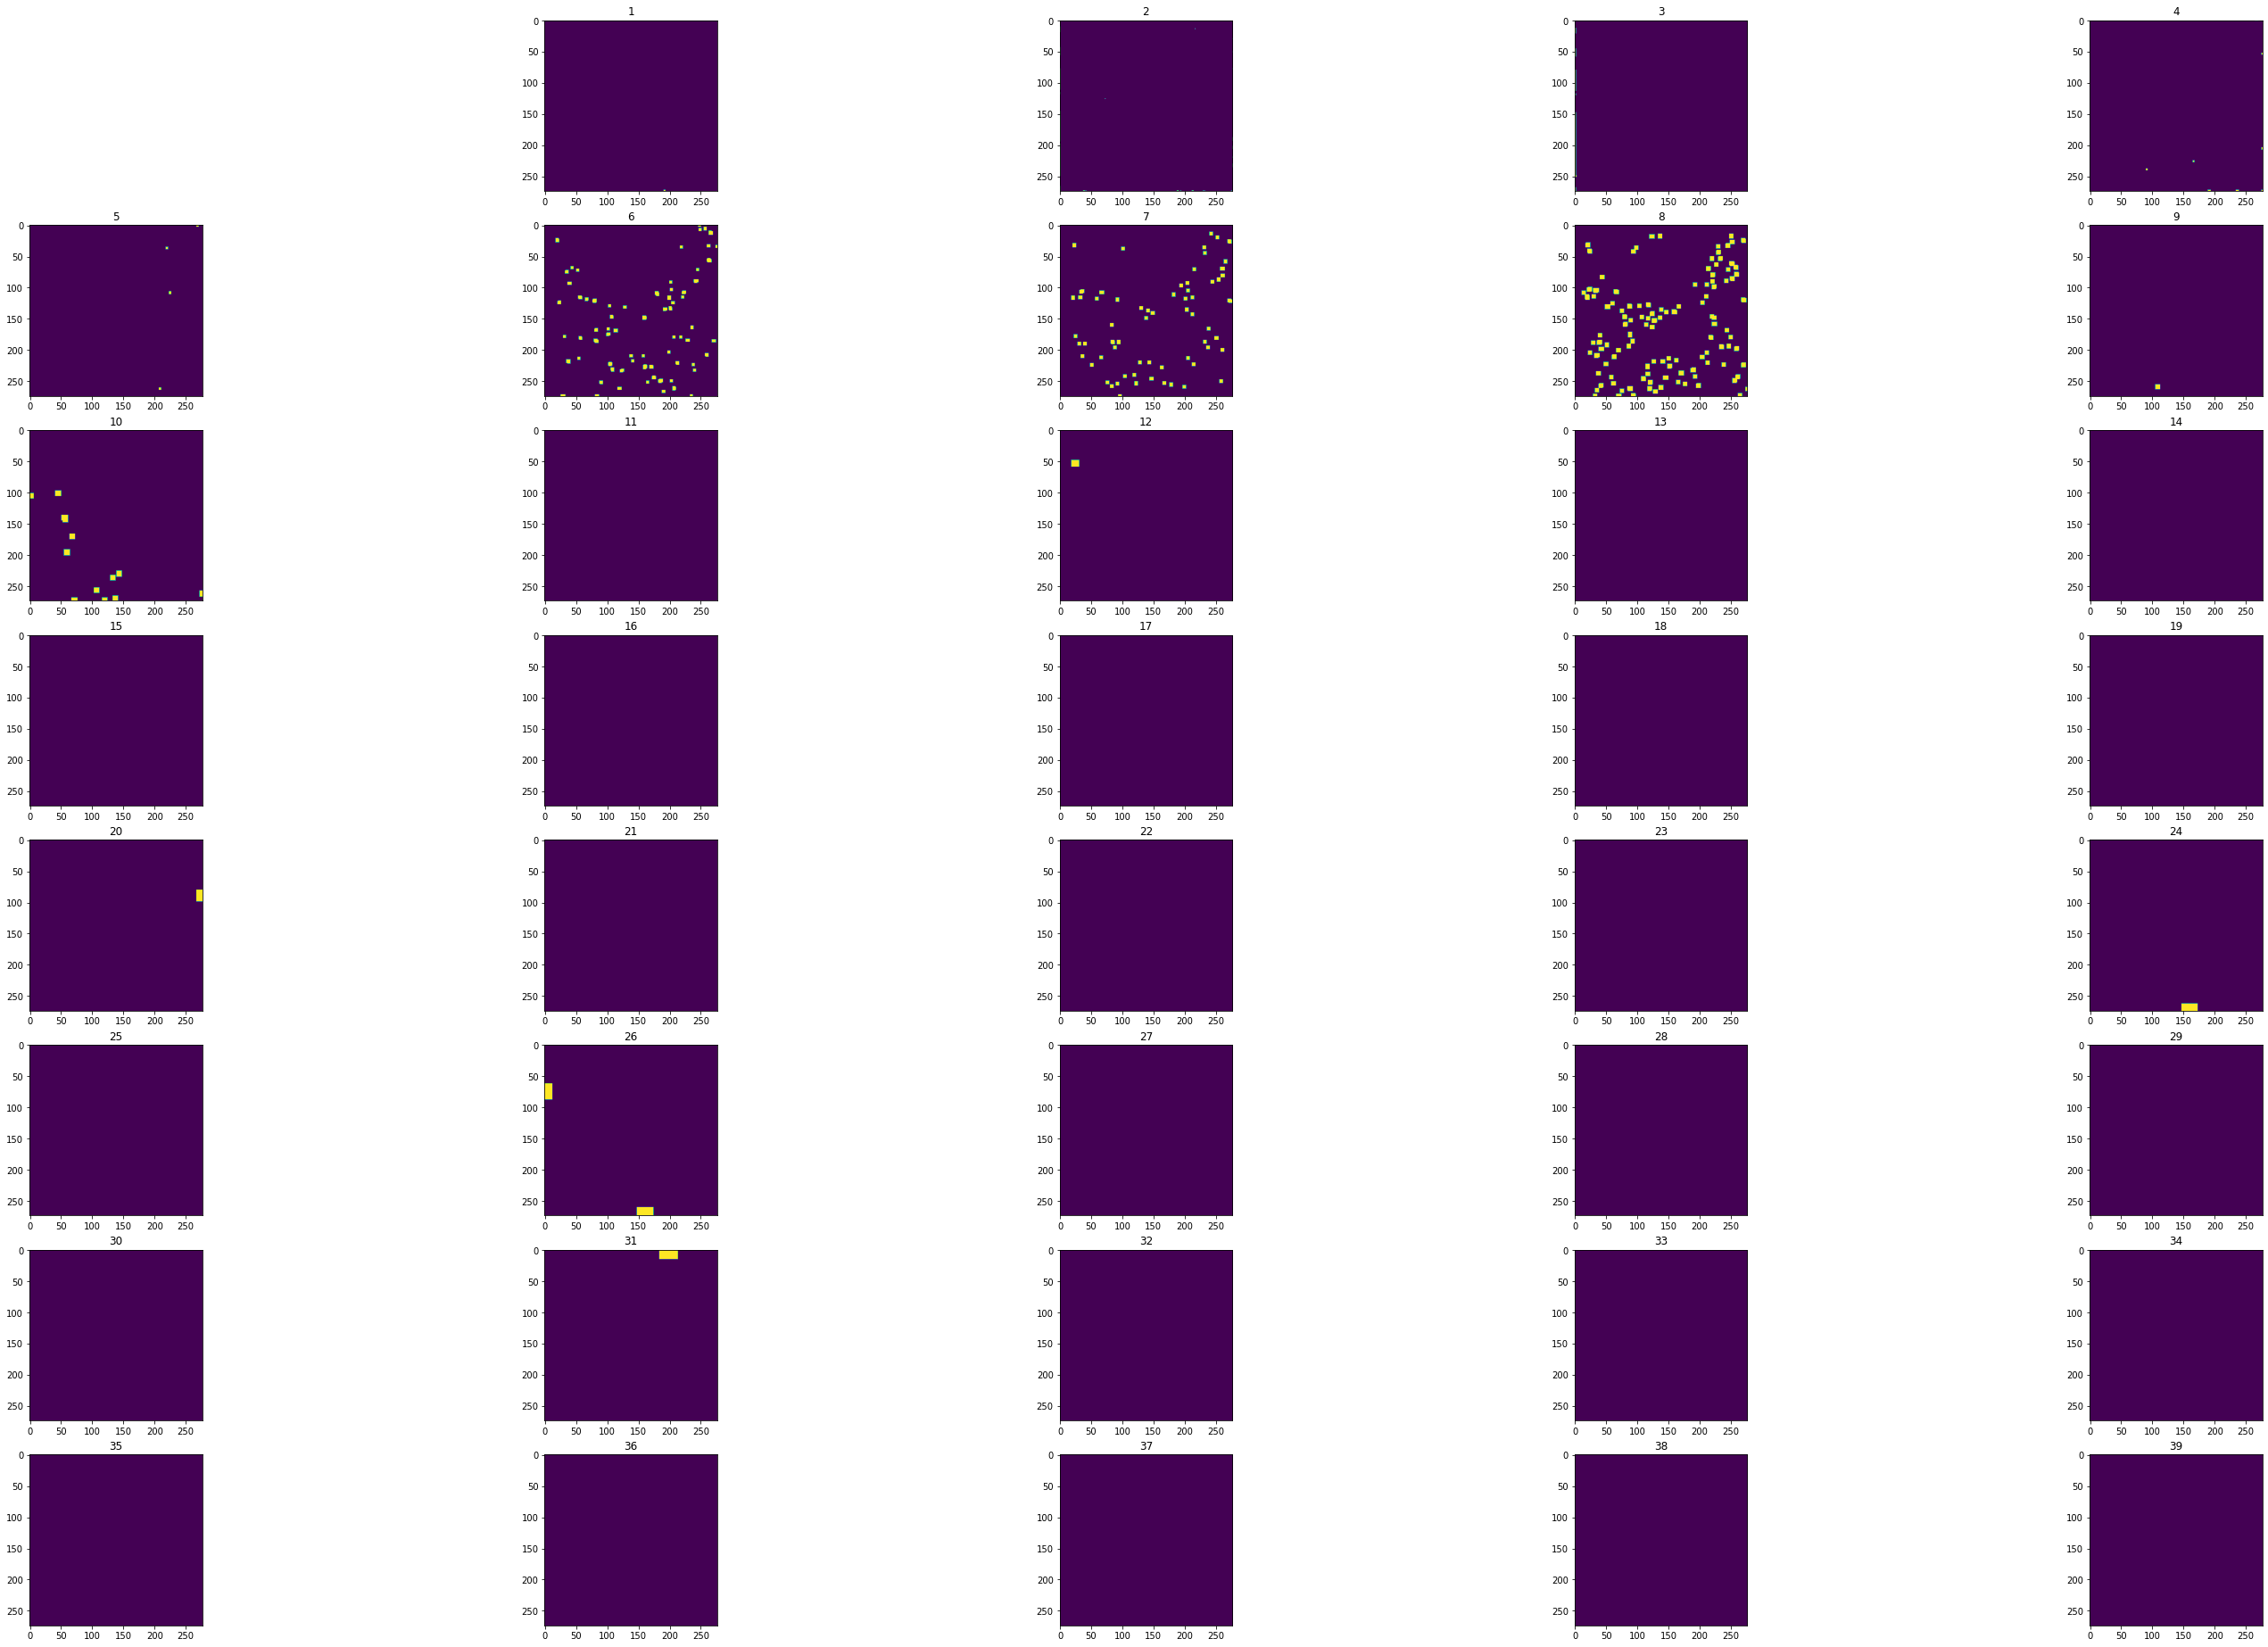

In [6]:
plt.figure(figsize=(50, 50))
#以步长为1，二值化阈值为50，发现kernel size小于15的可以很好的分离，但发现无法分离大球
num_particle=[0]#创建一个数组，用于存放粒子的数目
for n in range(1,40,1):
    result = white_Hat(n,1,50)
    #消除边框对粒子测度个数，尤其是小kernel的影响
    result = result[3:result.shape[0]-3,3:result.shape[1]-3]
    if(n<=15):
        num_particle.append(round(result.sum()/255/n/n))
    

<BarContainer object of 15 artists>

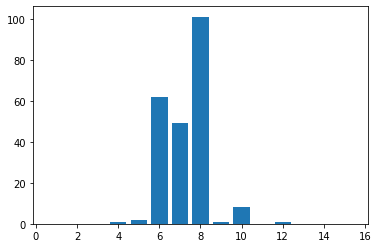

In [7]:
#画出前15个的对应粒子数目直方图
x = range(1,16)
x = np.array(x)

plt.bar(x,num_particle[1:16])

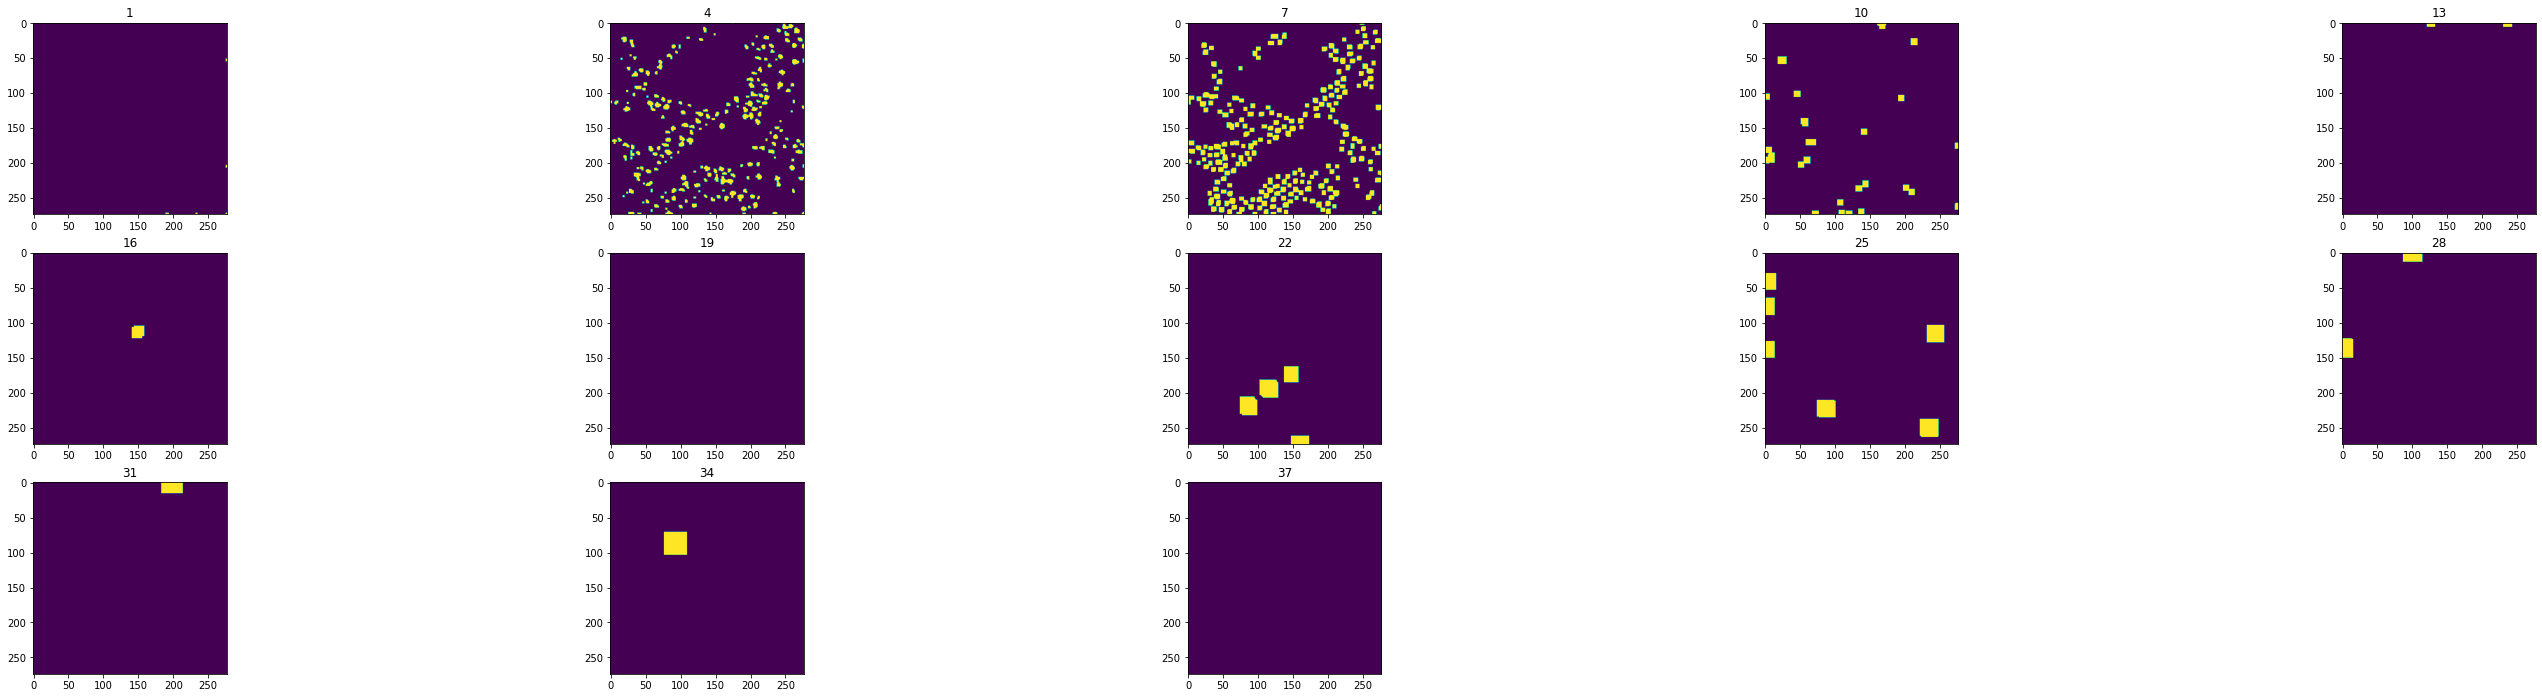

In [8]:
plt.figure(figsize=(50, 50))
#以步长为3，二值化阈值为50，可以较好的分离大球
for n in range(1,40,3):
    result = white_Hat(n,3,50)
    #消除边框对粒子测度个数，尤其是小kernel的影响
    result = result[3:result.shape[0]-3,3:result.shape[1]-3]
    if(n>15):#只统计n>15的数据
        num_particle.append(round(result.sum()/255/(n+1)/(n+1)))#取n到n+2的平均值n+1

Text(0, 0.5, 'No.')

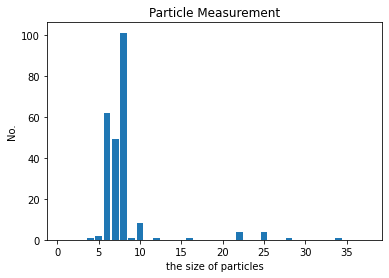

In [9]:
#与前15个合并，画出全部的对应粒子数目直方图
num_particle
x_1 = range(16,40,3)
x_1 = np.array(x_1)
y = np.concatenate([x, x_1])

plt.bar(y,num_particle[1:])
plt.title('Particle Measurement')
plt.xlabel("the size of particles")
plt.ylabel("No.")

Text(0, 0.5, 'Frequency')

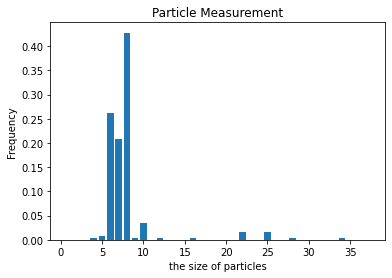

In [10]:
#转换为频率形式
plt.bar(y,np.array(num_particle[1:])/sum(num_particle))
plt.title('Particle Measurement')
plt.xlabel("the size of particles")
plt.ylabel("Frequency")

### 小结：
#### Step 1: 原始图像预处理
将原始图像转换为灰度图，并发现最后两列全为255，为避免影响需要对其进行切割
#### Step 2: 运用形态学变换筛选仅有单一粒子尺寸的图像
1）使用白顶帽变换，WTH(n+i)- WTH(n-1)保留size n～n+i-1的细节，其中`i`为步长  
2）进行二值化处理，突出粒子图像信息。如下列函数，其中`thred`为阈值  
`cv.threshold(dst, thred, 255, cv.THRESH_BINARY)`  
3）手动调整结构元大小`kernel`，步长`i`和阈值`thred`以得到清晰的目标图像进行粒子测度  
最终使用：  
$$
结构元相关参数=\begin{cases}  
步长为1，阈值为50 & 结构元<=15 \\
步长为3，阈值为50 & 结构元>15 \\
\end{cases}
$$


#### Step 3: 统计粒子数量
使用图像面积/结构元大小得到图像中对应的粒子数目，并绘制对应分布图。  
需要注意的是，对于小尺寸粒子的检测（如小于4）由于图像的四边可能有结构元没有处理到的，导致统计结果明显异常。因此需要对图像进行简单的切割，避免此影响，或者也可以直接忽略。

#### 得到分布图像如下
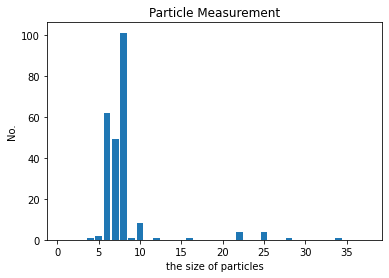
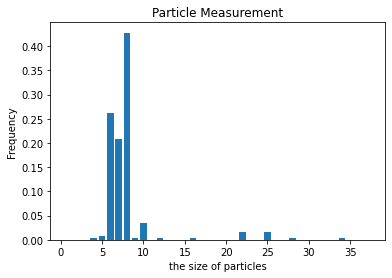